In [16]:
import sys, os
import json, pickle
import pandas as pd
from pathlib import Path
from xgboost import XGBClassifier

sys.path.append(str(Path.cwd().parent / "src"))
from config import get_model_config
from data_processing import get_features_and_target
from utils import calculate_metrics

In [47]:
# load configuration and saved XGBoost model
# Available COIN_ID options:
# - BTCUSDT: Bitcoin/USDT pair
# - ETHUSDT: Ethereum/USDT pair  
# - BNBUSDT: Binance Coin/USDT pair
# - SOLUSDT: Solana/USDT pair
# - XRPUSDT: Ripple/USDT pair

# Available FREQ (sampling frequency) options:
# - 10min: 10 minute intervals

COIN_ID = "XRPUSDT"
FREQ = "10min"       

config = get_model_config("xgboost", COIN_ID, FREQ, environment="development")

feature_selection_path = f'models/{COIN_ID}_{FREQ}/features.json'
with open(feature_selection_path, 'r') as f:
    features_list = json.load(f)
best_model_path = f"models/{COIN_ID}_{FREQ}/best_model.json"
tuning_result_path = f"models/{COIN_ID}_{FREQ}/tuning_results.pkl"
with open(tuning_result_path, 'rb') as f:
    search_results = pickle.load(f)

# load data

In [48]:
# load data
train, test = get_features_and_target(coin_id=COIN_ID, freq=FREQ, split=True)

target_col = config['data']['columns']['target']
X_train = train[features_list]
y_train = train[target_col]
X_test  = test[features_list]
y_test  = test[target_col]

Reducing memory usage for: processed_data
--- Memory usage before: 28.16 MB
--- Memory usage after: 15.59 MB
--- Decreased memory usage by 44.6%



In [49]:
# load model and predict
model = XGBClassifier()
model.load_model(best_model_path)

y_test_pred = model.predict(X_test)
y_test_pred_proba = getattr(model, 'predict_proba', lambda x: None)(X_test)
if y_test_pred_proba is not None:
    y_test_pred_proba = y_test_pred_proba[:, 1] if y_test_pred_proba.shape[1] > 1 else y_test_pred_proba.flatten()

test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba)

# backtest return

In [50]:
from strategy_simulation import calculate_single_coin_return
from KPI import calculate_performance_metrics
import matplotlib.pyplot as plt

In [51]:
result_cols = [config['data']['columns']['timestamp'], 'open', 'close']
result_df = test[result_cols].copy()
result_df['y_test_actual'] = test[target_col]
result_df['y_test_pred'] = y_test_pred
if y_test_pred_proba is not None:
    result_df['y_test_pred_prob'] = y_test_pred_proba

In [52]:
all_strategy_names = ['buy_and_hold', 'long_short', 'long_only', 'trend_following']
all_returns = dict()
for strategy in all_strategy_names:
    net_returns = calculate_single_coin_return(strategy, result_df=result_df)
    all_returns[strategy] = net_returns

timestamps = result_df['timestamp']

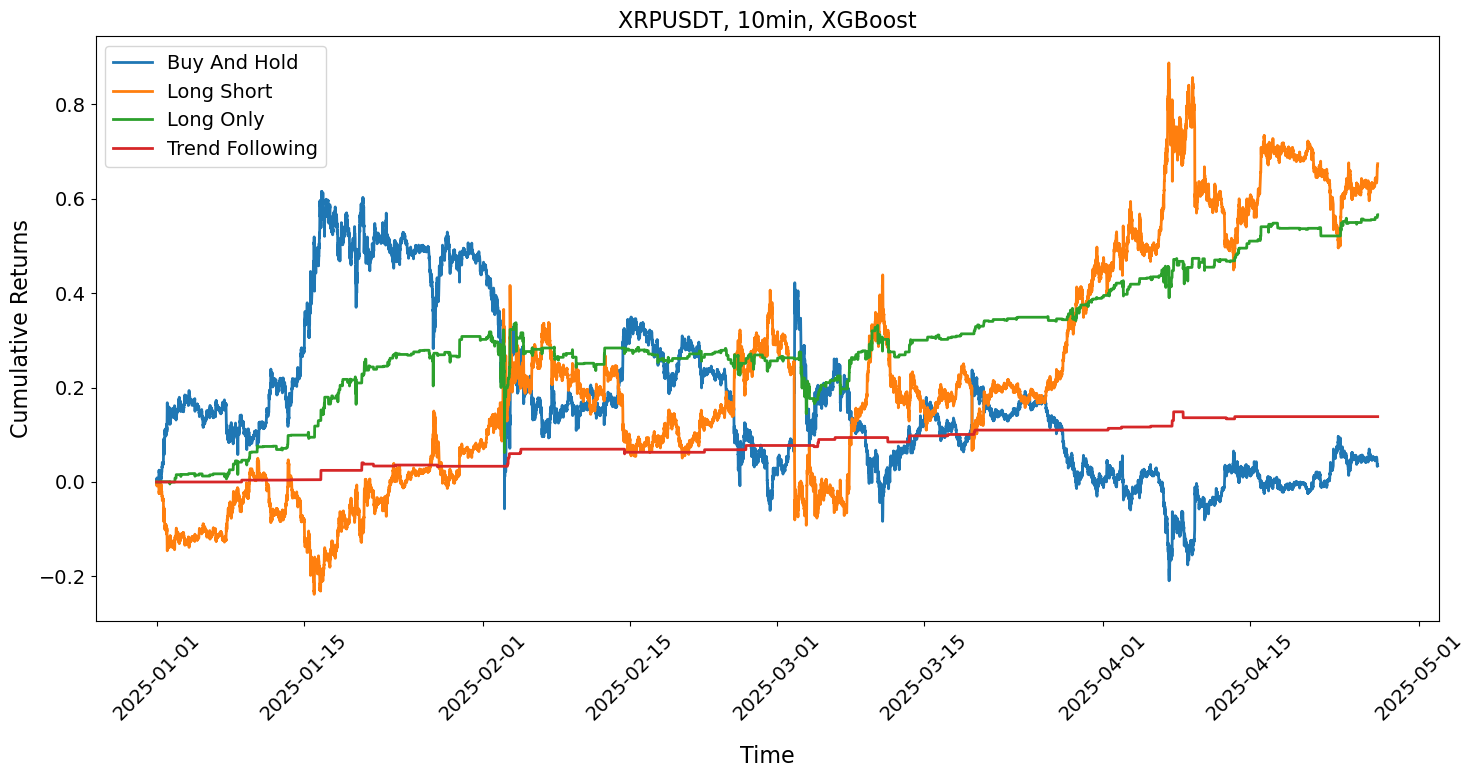

In [53]:
plt.figure(figsize=(15, 8))

plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

for strategy, returns in all_returns.items():
    cumulative_returns = (1 + returns).cumprod() - 1
    plt.plot(timestamps, cumulative_returns, label=strategy.replace('_', ' ').title(), linewidth=2)


plt.xlabel('Time', labelpad=15)
plt.ylabel('Cumulative Returns')
plt.title(f'{COIN_ID}, {FREQ}, XGBoost')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

os.makedirs('/fig/', exist_ok=True)
plt.savefig(f'/fig/{COIN_ID}_{FREQ}_cumulative_returns.png', 
            dpi=300, 
            bbox_inches='tight')

plt.show()

In [54]:
all_kpis = []
for strategy, return_series in all_returns.items():
    kpis = calculate_performance_metrics(returns_series=return_series, freq=FREQ)
    record = {'strategy': strategy, "coin_id": COIN_ID, **kpis}
    all_kpis.append(record)

kpi_df = pd.DataFrame(all_kpis)
kpi_df['frequency'] = FREQ
kpi_df['model'] = 'XGBoost'
kpi_df.reset_index(drop=True, inplace=True)
display(kpi_df)

,strategy,coin_id,Annualized Return,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Maximum Drawdown,Calmar Ratio,Kelly Criterion,frequency,model
0,buy_and_hold,XRPUSDT,0.017955,0.469136,0.038272,0.052403,-0.510441,0.035175,0.004625,10min,XGBoost
1,long_short,XRPUSDT,0.309766,0.469120,0.660312,0.804931,-0.358533,0.863981,0.013866,10min,XGBoost
2,long_only,XRPUSDT,0.264784,0.194911,1.358487,0.392126,-0.196597,1.346837,0.101493,10min,XGBoost
3,trend_following,XRPUSDT,0.070250,0.031765,2.211541,0.195873,-0.012978,5.413088,0.569949,10min,XGBoost


In [61]:
kpi_results_path = '.'
os.makedirs(kpi_results_path, exist_ok=True)

kpi_csv_path = os.path.join(kpi_results_path, 'all_coins_kpi_results.csv')

if os.path.exists(kpi_csv_path):
    existing_kpis = pd.read_csv(kpi_csv_path)
    existing_kpis = existing_kpis[~((existing_kpis['coin_id'] == COIN_ID) & 
                                  (existing_kpis['frequency'] == FREQ) &
                                  (existing_kpis['model'] == 'XGBoost'))]
    
    updated_kpis = pd.concat([existing_kpis, kpi_df], ignore_index=True)
else:
    updated_kpis = kpi_df

updated_kpis.to_csv(kpi_csv_path, index=False)
print(f"KPI results saved to: {kpi_csv_path}")

KPI results saved to: ./all_coins_kpi_results.csv
